In [1]:
import torch
from torch import optim
from torch import Tensor
from torch import nn
from torch.nn import functional as F

In [2]:
path_train = '/Users/liyuxiao/Downloads/CS2022/Deep Learning/data/train_data.pkl'
path_val = '/Users/liyuxiao/Downloads/CS2022/Deep Learning/data/val_data.pkl'

# 2 tensors of size 50000 x 3 x H x W
noisy_imgs_1, noisy_imgs_2 = torch.load(path_train)
noisy_imgs_1 = noisy_imgs_1[0:1000]
noisy_imgs_2 = noisy_imgs_2[0:1000]

noisy_imgs, clean_imgs = torch.load(path_val)
print(noisy_imgs_1.size())
print(noisy_imgs_2.size())
print(noisy_imgs.size())
print(clean_imgs.size())

torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])


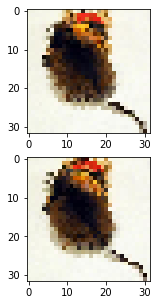

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as T 
from PIL import Image

transform = T.ToPILImage()

plt.figure(figsize = [10, 5])
plt.subplot(2,1,1)
plt.imshow(transform(noisy_imgs_1[100]));
plt.subplot(2,1,2)
plt.imshow(transform(noisy_imgs_2[100]));

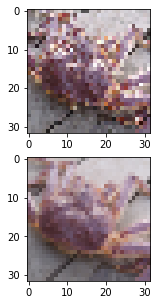

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize = [10, 5])
plt.subplot(2,1,1)
plt.imshow(transform(noisy_imgs[0]));
plt.subplot(2,1,2)
plt.imshow(transform(clean_imgs[0]));

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()
        # Layers: enc_conv0, enc_conv1, pool1
        self._block1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))

        # Layers: enc_conv(i), pool(i); i=2..5
        self._block2 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))

        # Layers: enc_conv6, upsample5
        self._block3 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_conv5a, dec_conv5b, upsample4
        self._block4 = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_deconv(i)a, dec_deconv(i)b, upsample(i-1); i=4..2
        self._block5 = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_conv1a, dec_conv1b, dec_conv1c,
        self._block6 = nn.Sequential(
            nn.Conv2d(96 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))

    def forward(self, x):
        # Encoder
        pool1 = self._block1(x)
        pool2 = self._block2(pool1)
        pool3 = self._block2(pool2)
        pool4 = self._block2(pool3)
        pool5 = self._block2(pool4)

        # Decoder
        upsample5 = self._block3(pool5)
        concat5 = torch.cat((upsample5, pool4), dim=1)
        upsample4 = self._block4(concat5)
        concat4 = torch.cat((upsample4, pool3), dim=1)
        upsample3 = self._block5(concat4)
        concat3 = torch.cat((upsample3, pool2), dim=1)
        upsample2 = self._block5(concat3)
        concat2 = torch.cat((upsample2, pool1), dim=1)
        upsample1 = self._block5(concat2)
        concat1 = torch.cat((upsample1, x), dim=1)

        # Final activation
        return self._block6(concat1)

In [7]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=3).to(device)

batch_size, nb_epochs = 100, 100
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
mse = nn.MSELoss()

for e in tqdm(range(nb_epochs)):
    input = noisy_imgs_1.to(device).type(torch.float).split(batch_size)
    target = noisy_imgs_2.to(device).type(torch.float).split(batch_size)
    for i in range(len(input)):
        output = model(input[i])
        loss = mse(output[i], target[i])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(transform(input[i][11]))
plt.subplot(1, 3, 2)
plt.imshow(transform(output[11]))
plt.subplot(1, 3, 3)
plt.imshow(transform(target[i][11]))

print(output[0].size(), target[0].size())

  0%|          | 0/100 [00:00<?, ?it/s]/Users/liyuxiao/opt/anaconda3/envs/epfl/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100, 3, 32, 32])) that is different to the input size (torch.Size([3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/100 [00:05<?, ?it/s]


KeyboardInterrupt: 